***
### **Amazon Fine Food Reviews : Analyze ~500,000 food reviews from Amazon**
***
#### **Context:** 
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

#### **Data includes:**
* Reviews from Oct 1999 - Oct 2012
* 568,454 reviews
* 256,059 users
* 74,258 products
* 260 users with > 50 reviews

#### **Source:**
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import seaborn as sns
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import NaiveBayes, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import numpy as np

### 1. Load dataset in HDFS

In [3]:
spark = SparkSession.builder.appName("Read CSV from HDFS").config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").getOrCreate()
df = spark.read.csv("hdfs://namenode:9000/Reviews.csv", header=True)
df_pandas =df.toPandas()
spark.stop()
df_pandas

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"""Product arrived labeled as Jumbo Salted Peanu..."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"""Natalia Corres """"Natalia Corres""""""",1,1,4,1219017600,"""""""Delight"""" says it all""","""This is a confection that has been around a f..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"""Michael D. Bigham """"M. Wassir""""""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"""pksd """"pk_007""""""",2,2,5,1329782400,Perfect for our maltipoo,"""These stars are small, so you can give 10-15 ..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"""Kathy A. Welch """"katwel""""""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


### 2. Checking Information Dataset

In [41]:
print("Rows: \n", df_pandas.count(),"\n")
print("The names of columns: \n", df_pandas.columns,"\n")
print("Types of columns: \n", df_pandas.dtypes,"\n")

Rows: 
 Id                        568454
ProductId                 568454
UserId                    568454
ProfileName               568454
HelpfulnessNumerator      568452
HelpfulnessDenominator    568452
Score                     568451
Time                      568449
Summary                   568448
Text                      568444
dtype: int64 

The names of columns: 
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object') 

Types of columns: 
 Id                        object
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator      object
HelpfulnessDenominator    object
Score                     object
Time                      object
Summary                   object
Text                      object
dtype: object 



### 3. Checking Null Values and Duplicated Data

In [42]:
print("The number of null values:\n", df_pandas.isnull().sum())
print("The number of duplicagted data: ", df_pandas.duplicated().sum())

The number of null values:
 Id                         0
ProductId                  0
UserId                     0
ProfileName                0
HelpfulnessNumerator       2
HelpfulnessDenominator     2
Score                      3
Time                       5
Summary                    6
Text                      10
dtype: int64
The number of duplicagted data:  0


### 4. Data Cleaning

In [43]:
columns_to_check = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time']
df_pandas = df_pandas.dropna(subset=columns_to_check, how='any')
df_pandas['HelpfulnessNumerator'] = pd.to_numeric(df_pandas['HelpfulnessNumerator'], errors='coerce')
df_pandas['HelpfulnessDenominator'] = pd.to_numeric(df_pandas['HelpfulnessDenominator'], errors='coerce')
df_pandas['Score'] = pd.to_numeric(df_pandas['Score'], errors='coerce')
df_pandas['Time'] = pd.to_numeric(df_pandas['Time'], errors='coerce')
df_pandas.isna().sum()

/var/folders/jb/tfwdgvdn69n2mpzr99z3z1400000gn/T/ipykernel_20316/3029863066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pandas['HelpfulnessNumerator'] = pd.to_numeric(df_pandas['HelpfulnessNumerator'], errors='coerce')
/var/folders/jb/tfwdgvdn69n2mpzr99z3z1400000gn/T/ipykernel_20316/3029863066.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pandas['HelpfulnessDenominator'] = pd.to_numeric(df_pandas['HelpfulnessDenominator'], errors='coerce')
/var/folders/jb/tfwdgvdn69n2mpzr99z3z1400000gn/T

Id                           0
ProductId                    0
UserId                       0
ProfileName                  0
HelpfulnessNumerator      2746
HelpfulnessDenominator     881
Score                      287
Time                         8
Summary                      1
Text                         5
dtype: int64

### 5. Impute Missing Values

In [44]:
df_pandas['HelpfulnessNumerator'].fillna(df_pandas['HelpfulnessNumerator'].median(), inplace=True)
df_pandas['HelpfulnessDenominator'].fillna(df_pandas['HelpfulnessDenominator'].median(), inplace=True)
df_pandas['Score'].fillna(df_pandas['Score'].mode()[0], inplace=True)
df_pandas['Time'].fillna(df_pandas['Time'].median(), inplace=True)
df_pandas['Time'] = df_pandas['Time'].replace(0, df_pandas['Time'].median())
df_pandas.dropna(subset=['Summary', 'Text'], inplace=True)
df_pandas.isna().sum()

/var/folders/jb/tfwdgvdn69n2mpzr99z3z1400000gn/T/ipykernel_20316/3653092306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pandas['HelpfulnessNumerator'].fillna(df_pandas['HelpfulnessNumerator'].median(), inplace=True)
/var/folders/jb/tfwdgvdn69n2mpzr99z3z1400000gn/T/ipykernel_20316/3653092306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pandas['HelpfulnessDenominator'].fillna(df_pandas['HelpfulnessDenominator'].median(), inplace=True)
/var/folders/jb/tfwdgvdn69n2mpzr99z3z1400000gn/T/ipykernel_20316/3653092306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

### 6. Exploratory Data Analysis (EDA)

In [45]:
print("Summary Statistics: \n", df_pandas.describe())

Summary Statistics: 
        HelpfulnessNumerator  HelpfulnessDenominator          Score  \
count         568444.000000           568444.000000  568444.000000   
mean               1.732044                2.223394       4.176714   
std                7.624070                8.281358       1.383656   
min                0.000000                0.000000       0.000000   
25%                0.000000                0.000000       4.000000   
50%                0.000000                1.000000       5.000000   
75%                2.000000                2.000000       5.000000   
max              866.000000              923.000000      69.000000   

               Time  
count  5.684440e+05  
mean   1.290846e+09  
std    9.671249e+07  
min    1.000000e+00  
25%    1.270685e+09  
50%    1.310861e+09  
75%    1.332634e+09  
max    1.351210e+09  


### 6.1 Histrogram plot

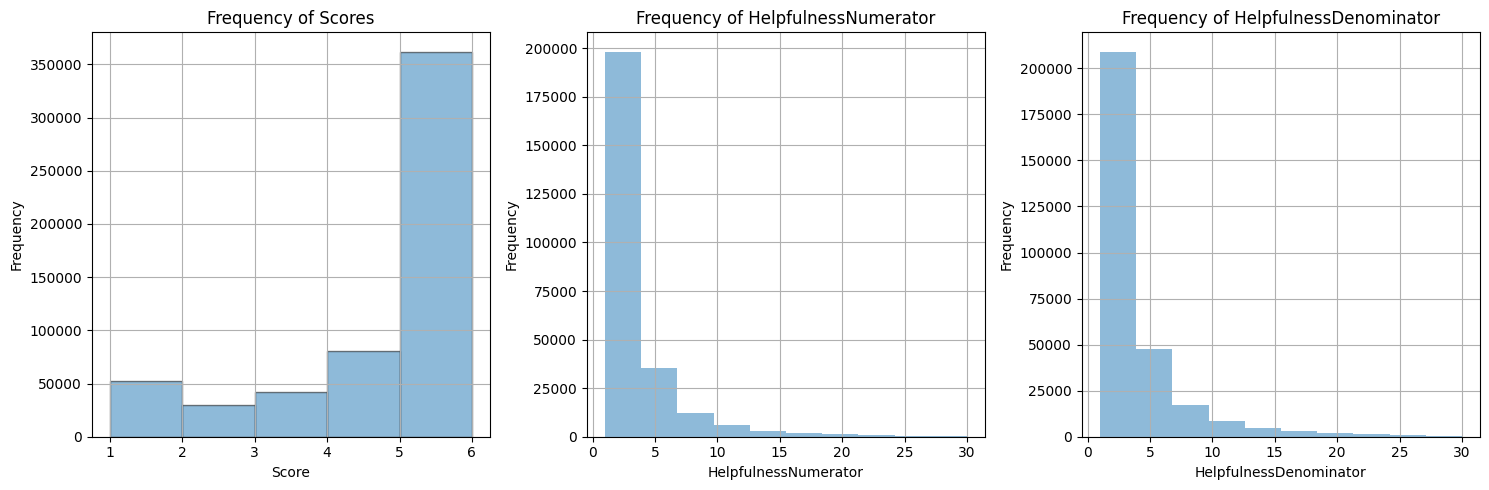

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_pandas['Score'], bins=[1, 2, 3, 4, 5, 6], edgecolor='k', alpha=0.5)
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Frequency of Scores')
axes[0].grid(True)

axes[1].hist(df_pandas['HelpfulnessNumerator'],range=(1,30), alpha=0.5)
axes[1].set_xlabel('HelpfulnessNumerator')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Frequency of HelpfulnessNumerator')
axes[1].grid(True)

axes[2].hist(df_pandas['HelpfulnessDenominator'],range=(1,30), alpha=0.5)
axes[2].set_xlabel('HelpfulnessDenominator')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Frequency of HelpfulnessDenominator')
axes[2].grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### 6.2 Heat map

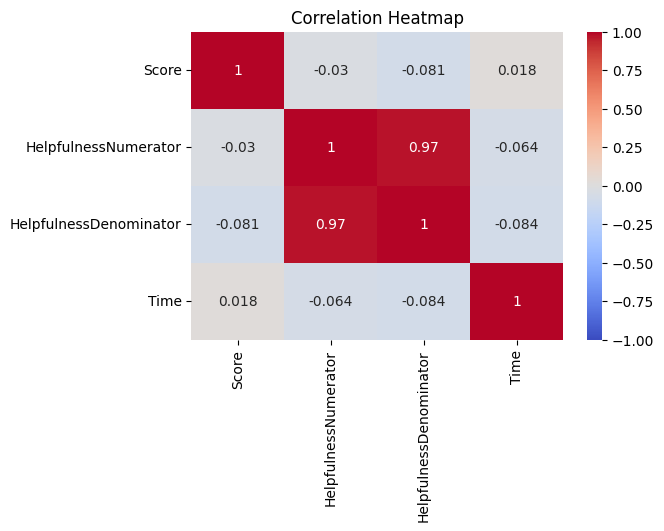

In [47]:
heatmap_data = df_pandas[['Score','HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']]

correlation_matrix = heatmap_data.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

plt.show()

### Functions

In [48]:
def pipeline_stage():
    tokenizer = Tokenizer(inputCol="Text", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered")
    hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=15000)
    idf = IDF(inputCol="rawFeatures", outputCol="features")
    return tokenizer, remover, hashingTF, idf

def calculate_roc_curve(true_labels, predicted_probabilities):
    thresholds = np.arange(0, 1.01, 0.01)
    tpr = []  # True Positive Rate
    fpr = []  # False Positive Rate

    for threshold in thresholds:
        predicted_labels = [1 if prob[1] >= threshold else 0 for prob in predicted_probabilities]
        true_positive = sum(1 for i in range(len(true_labels)) if true_labels[i] == 1 and predicted_labels[i] == 1)
        false_positive = sum(1 for i in range(len(true_labels)) if true_labels[i] == 0 and predicted_labels[i] == 1)
        true_negative = sum(1 for i in range(len(true_labels)) if true_labels[i] == 0 and predicted_labels[i] == 0)
        false_negative = sum(1 for i in range(len(true_labels)) if true_labels[i] == 1 and predicted_labels[i] == 0)

        tpr.append(true_positive / (true_positive + false_negative))
        fpr.append(false_positive / (false_positive + true_negative))

    return fpr, tpr, thresholds

def plot_confusion_matrix(true_labels, predicted_labels):
    unique_labels = list(set(true_labels + predicted_labels))
    num_labels = len(unique_labels)
    
    confusion_matrix = np.zeros((num_labels, num_labels), dtype=int)
    
    for i in range(len(true_labels)):
        true_label_idx = unique_labels.index(true_labels[i])
        predicted_label_idx = unique_labels.index(predicted_labels[i])
        confusion_matrix[true_label_idx][predicted_label_idx] += 1

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(num_labels)
    plt.xticks(tick_marks, unique_labels)
    plt.yticks(tick_marks, unique_labels)

    for i in range(num_labels):
        for j in range(num_labels):
            plt.text(j, i, str(confusion_matrix[i][j]), horizontalalignment="center", color="black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

### 7. NaiveBayes

In [49]:
spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()
spark_df = spark.createDataFrame(df_pandas.head(70000))

spark_df = spark_df.withColumn("Sentiment", when(col("Score") >= 4, 1).otherwise(0))
tokenizer, remover, hashingTF, idf= pipeline_stage()
nb = NaiveBayes(modelType="multinomial", labelCol="Sentiment", featuresCol="features")
sentiment_pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, nb])
train_data, test_data = spark_df.randomSplit([0.7, 0.3], seed=42)
numFolds_list = [3,5,7,9]
for numFolds in numFolds_list:
    paramGrid = (ParamGridBuilder()
                 .addGrid(nb.smoothing, [0.001, 0.01, 0.1, 1.0, 1.5, 2.0])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction")
    crossval = CrossValidator(estimator=sentiment_pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=numFolds)
    cvModel = crossval.fit(train_data)
    bestModel = cvModel.bestModel
    sentiment_predictions = bestModel.transform(test_data)

/Users/ayoucruz/miniconda3/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
23/10/20 03:44:02 WARN StopWordsRemover: Default locale set was [en_TH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
23/10/20 03:44:02 WARN StopWordsRemover: Default locale set was [en_TH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
23/10/20 03:44:02 WARN StopWordsRemover: Default locale set was [en_TH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
23/10/20 03:44:03 WARN TaskSetManager: 

### 7.1 NaiveBayes - Evaluation

In [50]:
accuracy = evaluator.evaluate(sentiment_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(sentiment_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(sentiment_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(sentiment_predictions, {evaluator.metricName: "f1"})
bi_evaluator = BinaryClassificationEvaluator(labelCol="Sentiment", rawPredictionCol='probability')
auc = bi_evaluator.evaluate(sentiment_predictions, {bi_evaluator.metricName:"areaUnderROC"})
print(f"Accuracy: {accuracy * 100}%")
print(f"Precision: {precision*100}%")
print(f"Recall: {recall*100}%")
print(f"F1-score: {f1*100}%")
print(f"AUC: {auc * 100:.2f}%")

23/10/20 04:05:23 WARN TaskSetManager: Stage 1076 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 04:05:27 WARN TaskSetManager: Stage 1078 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 04:05:30 WARN TaskSetManager: Stage 1080 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 04:05:33 WARN TaskSetManager: Stage 1082 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 04:05:35 WARN TaskSetManager: Stage 1084 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 81.4042388464144%
Precision: 82.72804098777411%
Recall: 81.4042388464144%
F1-score: 81.91221012788952%
AUC: 84.39%


### 7.2 NaiveBayes - Histogram

23/10/20 04:05:46 WARN TaskSetManager: Stage 1095 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 04:05:49 WARN TaskSetManager: Stage 1096 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


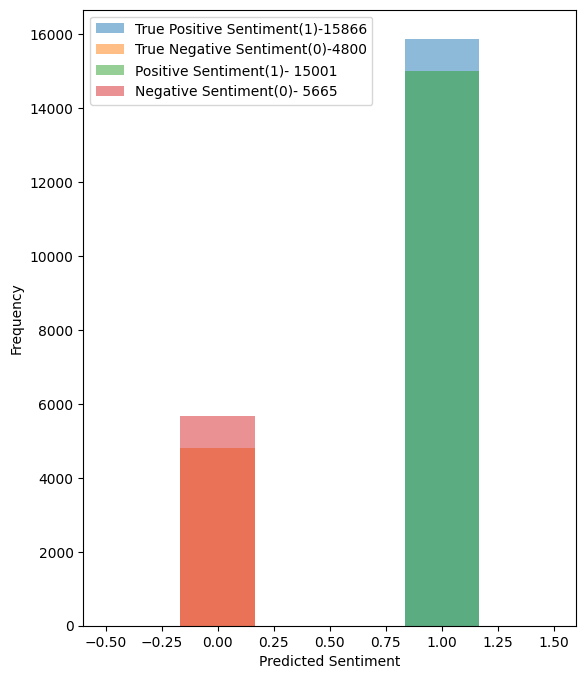

In [51]:
true_sentiments = sentiment_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_sentiments = sentiment_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

positive_true = [pred for pred in true_sentiments if pred ==1]
negative_true = [pred for pred in true_sentiments if pred ==0]
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 2)
plt.hist(positive_true, bins=3, alpha=0.5, label=f'True Positive Sentiment(1)-{len(positive_true)}')
plt.hist(negative_true, bins=3, alpha=0.5, label=f'True Negative Sentiment(0)-{len(negative_true)}')
plt.xlabel('True Sentiment')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
positive_predictions = [pred for pred in predicted_sentiments if pred == 1]
negative_predictions = [pred for pred in predicted_sentiments if pred == 0]

plt.hist(positive_predictions, bins=3, alpha=0.5, label=f'Positive Sentiment(1)- {len(positive_predictions)}')
plt.hist(negative_predictions, bins=3, alpha=0.5, label=f'Negative Sentiment(0)- {len(negative_predictions)}')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Frequency')
plt.legend()

plt.show()

### 7.3 NaiveBayes - Confusion Matrix

23/10/20 04:05:57 WARN TaskSetManager: Stage 1097 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 04:05:59 WARN TaskSetManager: Stage 1098 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


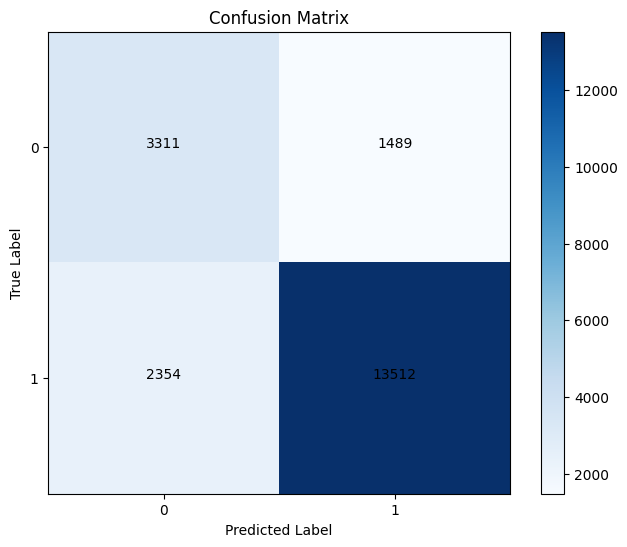

In [52]:
true_sentiments = sentiment_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_sentiments = sentiment_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 6))
plot_confusion_matrix(true_sentiments, predicted_sentiments)
plt.show()

### 7.4 NaiveBayes - ROC CURVE

23/10/20 04:06:17 WARN TaskSetManager: Stage 1099 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 04:06:19 WARN TaskSetManager: Stage 1100 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


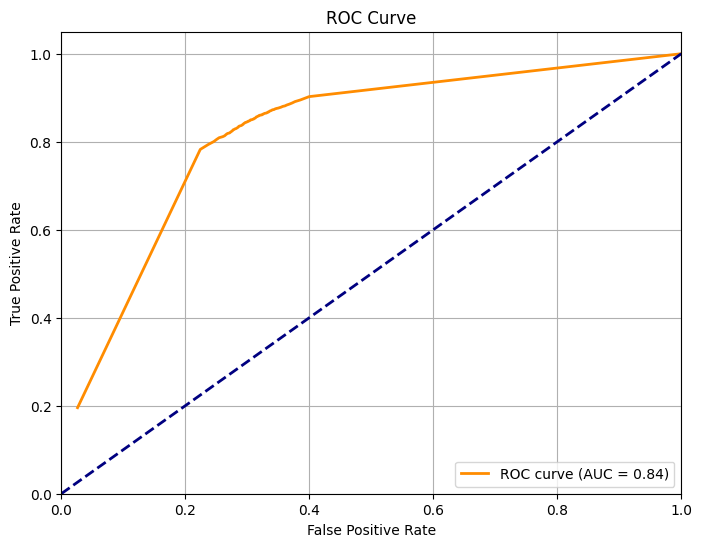

In [53]:
true_sentiments = sentiment_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_probs = sentiment_predictions.select('probability').rdd.flatMap(lambda x: x).collect()

true_binary = [1 if sentiment == 1 else 0 for sentiment in true_sentiments]
fpr, tpr, _ = calculate_roc_curve(true_binary, predicted_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
spark.stop()

### 8. Logistic Regression

In [14]:
spark = SparkSession.builder.appName("LogisticRegression").getOrCreate()
spark_df = spark.createDataFrame(df_pandas.head(70000))
spark_df = spark_df.withColumn("Sentiment", when(col("Score") >= 4, 1).otherwise(0))
tokenizer, remover, hashingTF, idf= pipeline_stage()
lr = LogisticRegression(labelCol='Sentiment', featuresCol='features', regParam=0.01, elasticNetParam=0)
lr_pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
train_data, test_data = spark_df.randomSplit([0.7, 0.3], seed=42)
model = lr_pipeline.fit(train_data)
lr_predictions = model.transform(test_data)

23/10/20 02:26:02 WARN StopWordsRemover: Default locale set was [en_TH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
23/10/20 02:26:03 WARN TaskSetManager: Stage 112 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:26:07 WARN TaskSetManager: Stage 114 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:26:10 WARN TaskSetManager: Stage 116 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:26:15 WARN TaskSetManager: Stage 118 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:26:17 WARN TaskSetManager: Stage 120 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:26:19 WARN TaskSetManager: Stage 122 contains a task of very

### 8.1 Logistic Regression - Evaluation

In [15]:
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction")
accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName:"accuracy"})
precision = evaluator.evaluate(lr_predictions, {evaluator.metricName:"weightedPrecision"})
recall = evaluator.evaluate(lr_predictions, {evaluator.metricName:"weightedRecall"})
f1 = evaluator.evaluate(lr_predictions, {evaluator.metricName:"f1"})
bi_evaluator = BinaryClassificationEvaluator(labelCol="Sentiment", rawPredictionCol='probability')
auc = bi_evaluator.evaluate(lr_predictions, {bi_evaluator.metricName:"areaUnderROC"})
print(f"Accuracy: {accuracy * 100}%")
print(f"Precision: {precision * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1-Score: {f1 * 100}%")
print(f"AUC: {auc * 100:.2f}%")

23/10/20 02:27:43 WARN TaskSetManager: Stage 224 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:27:47 WARN TaskSetManager: Stage 226 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:27:50 WARN TaskSetManager: Stage 228 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:27:53 WARN TaskSetManager: Stage 230 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:27:55 WARN TaskSetManager: Stage 232 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 84.39949675795994%
Precision: 83.74862279426414%
Recall: 84.39949675795994%
F1-Score: 83.94438858207013%
AUC: 84.99%


### 8.2 Logistic Regression - Histogram

23/10/20 02:28:06 WARN TaskSetManager: Stage 243 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:28:07 WARN TaskSetManager: Stage 244 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


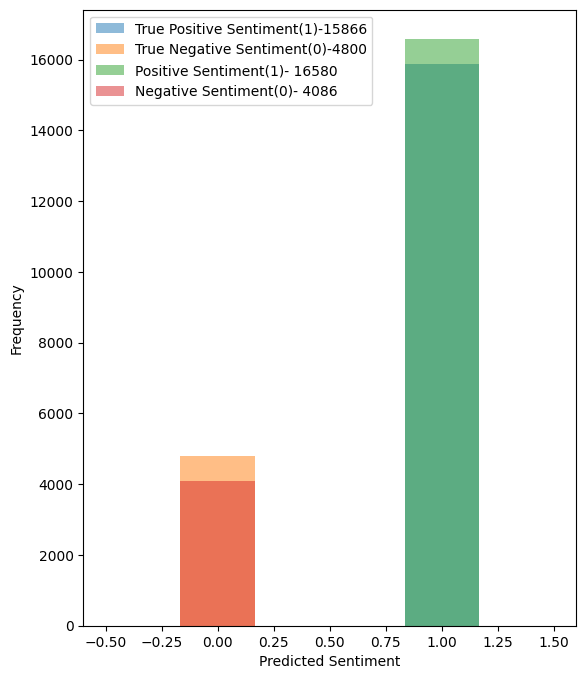

In [16]:
true_sentiments = lr_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_sentiments = lr_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

positive_true = [pred for pred in true_sentiments if pred ==1]
negative_true = [pred for pred in true_sentiments if pred ==0]

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 2)
plt.hist(positive_true, bins=3, alpha=0.5, label=f'True Positive Sentiment(1)-{len(positive_true)}')
plt.hist(negative_true, bins=3, alpha=0.5, label=f'True Negative Sentiment(0)-{len(negative_true)}')
plt.xlabel('True Sentiment')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
positive_predictions = [pred for pred in predicted_sentiments if pred == 1]
negative_predictions = [pred for pred in predicted_sentiments if pred == 0]

plt.hist(positive_predictions, bins=3, alpha=0.5, label=f'Positive Sentiment(1)- {len(positive_predictions)}')
plt.hist(negative_predictions, bins=3, alpha=0.5, label=f'Negative Sentiment(0)- {len(negative_predictions)}')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Frequency')
plt.legend()

plt.show()

### 8.3 Logistic Regression - Confusion Matrix

23/10/20 02:32:58 WARN TaskSetManager: Stage 249 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:33:00 WARN TaskSetManager: Stage 250 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


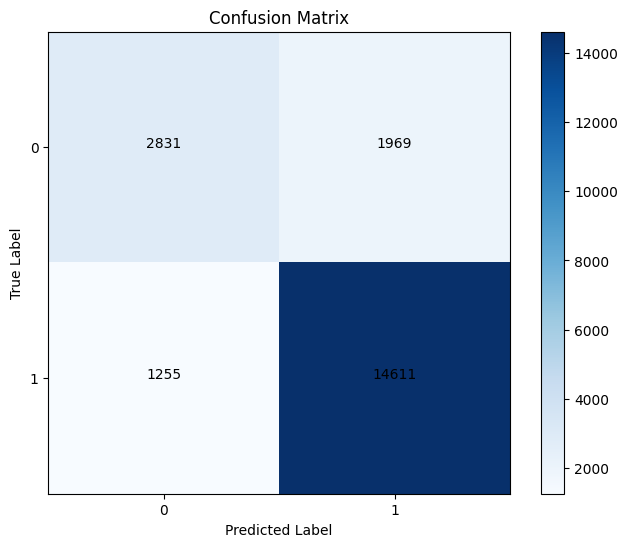

In [20]:
true_sentiments = lr_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_sentiments = lr_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 6))
plot_confusion_matrix(true_sentiments, predicted_sentiments)
plt.show()

### 8.4 Logistic Regression - ROC CURVE

23/10/20 02:28:21 WARN TaskSetManager: Stage 247 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:28:23 WARN TaskSetManager: Stage 248 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


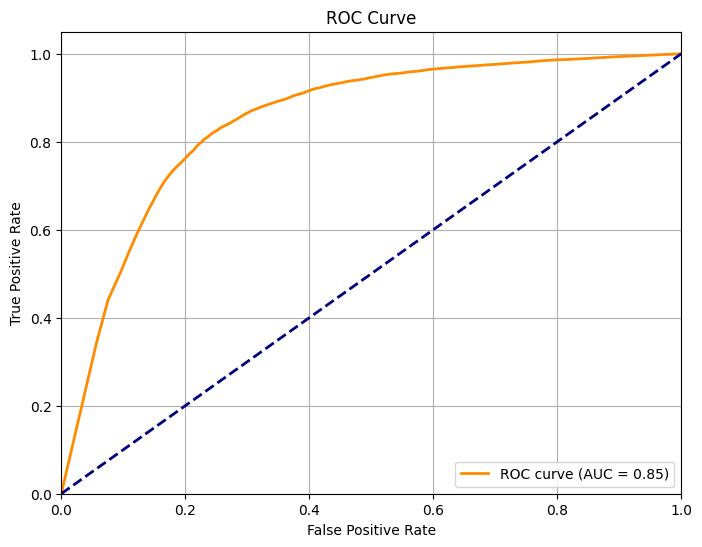

In [18]:
true_sentiments = lr_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_probs = lr_predictions.select('probability').rdd.flatMap(lambda x: x).collect()

true_binary = [1 if sentiment == 1 else 0 for sentiment in true_sentiments]

fpr, tpr, _ = calculate_roc_curve(true_binary, predicted_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [24]:
spark = SparkSession.builder.appName("DecisionTree").getOrCreate()
spark_df = spark.createDataFrame(df_pandas.head(70000))

spark_df = spark_df.withColumn("Sentiment", when(col("Score") >= 4, 1).otherwise(0))
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=15000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

dt = DecisionTreeClassifier(labelCol="Sentiment", featuresCol="features")

param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15, 20]) \
    .build()

dt_pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, dt])

evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction")

crossval = CrossValidator(estimator=dt_pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
train_data, test_data = spark_df.randomSplit([0.7, 0.3], seed=42)
cv_model = crossval.fit(train_data)
best_model = cv_model.bestModel
dt_predictions = best_model.transform(test_data)

23/10/20 02:57:45 WARN StopWordsRemover: Default locale set was [en_TH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
23/10/20 02:57:45 WARN StopWordsRemover: Default locale set was [en_TH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
23/10/20 02:57:45 WARN StopWordsRemover: Default locale set was [en_TH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
23/10/20 02:57:46 WARN TaskSetManager: Stage 0 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:57:48 WARN TaskSetManager: Stage 1 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 02:57:53 WARN TaskSetManager: Stage 3 contains a task of very large si

### 9.1 Decision Tree - Evaluation

In [25]:
accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName:"accuracy"})
precision = evaluator.evaluate(dt_predictions, {evaluator.metricName:"weightedPrecision"})
recall = evaluator.evaluate(dt_predictions, {evaluator.metricName:"weightedRecall"})
f1 = evaluator.evaluate(dt_predictions, {evaluator.metricName:"f1"})
bi_evaluator = BinaryClassificationEvaluator(labelCol="Sentiment", rawPredictionCol='probability')
auc = bi_evaluator.evaluate(dt_predictions, {bi_evaluator.metricName:"areaUnderROC"})
print(f"Accuracy: {accuracy * 100}%")
print(f"Precision: {precision * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1-Score: {f1 * 100}%")
print(f"AUC: {auc * 100:.2f}%")

23/10/20 03:10:01 WARN TaskSetManager: Stage 487 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:10:03 WARN TaskSetManager: Stage 489 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:10:06 WARN TaskSetManager: Stage 491 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:10:09 WARN TaskSetManager: Stage 493 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:10:16 WARN TaskSetManager: Stage 495 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 78.10413239136747%
Precision: 74.86714330693725%
Recall: 78.10413239136747%
F1-Score: 74.20582514134827%
AUC: 72.03%


### 9.2 Decision Tree - Histogram

23/10/20 03:10:21 WARN TaskSetManager: Stage 506 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:10:22 WARN TaskSetManager: Stage 507 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


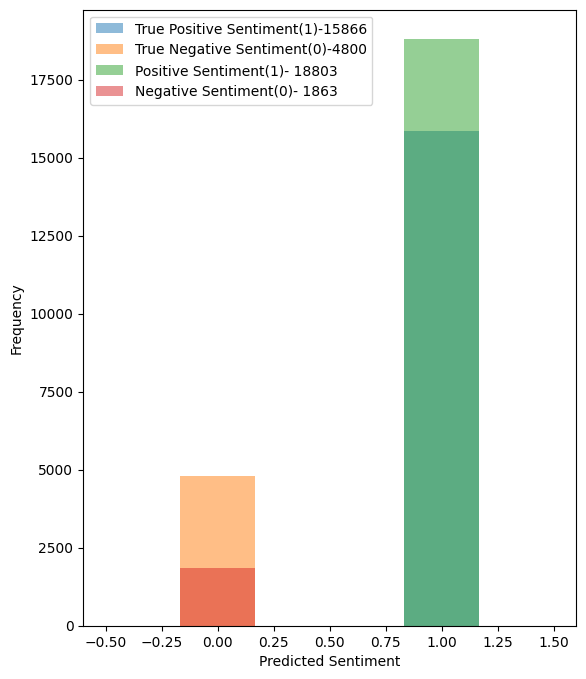

In [26]:
true_sentiments = dt_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_sentiments = dt_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

positive_true = [pred for pred in true_sentiments if pred ==1]
negative_true = [pred for pred in true_sentiments if pred ==0]
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 2)
plt.hist(positive_true, bins=3, alpha=0.5, label=f'True Positive Sentiment(1)-{len(positive_true)}')
plt.hist(negative_true, bins=3, alpha=0.5, label=f'True Negative Sentiment(0)-{len(negative_true)}')
plt.xlabel('True Sentiment')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
positive_predictions = [pred for pred in predicted_sentiments if pred == 1]
negative_predictions = [pred for pred in predicted_sentiments if pred == 0]

plt.hist(positive_predictions, bins=3, alpha=0.5, label=f'Positive Sentiment(1)- {len(positive_predictions)}')
plt.hist(negative_predictions, bins=3, alpha=0.5, label=f'Negative Sentiment(0)- {len(negative_predictions)}')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Frequency')
plt.legend()

plt.show()

### 9.3 Decision Tree - Confusion Matrix

23/10/20 03:10:37 WARN TaskSetManager: Stage 508 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:10:38 WARN TaskSetManager: Stage 509 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


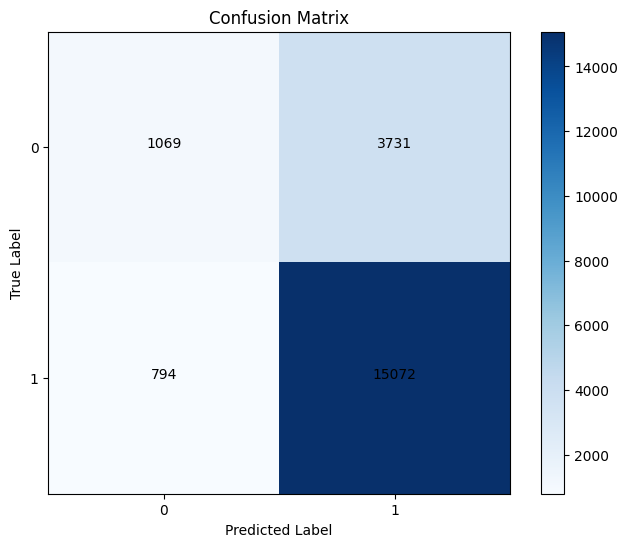

In [27]:
true_sentiments = dt_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_sentiments = dt_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 6))
plot_confusion_matrix(true_sentiments, predicted_sentiments)
plt.show()

### 9.4 Decision Tree - ROC CURVE

23/10/20 03:10:46 WARN TaskSetManager: Stage 510 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:10:46 WARN TaskSetManager: Stage 511 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


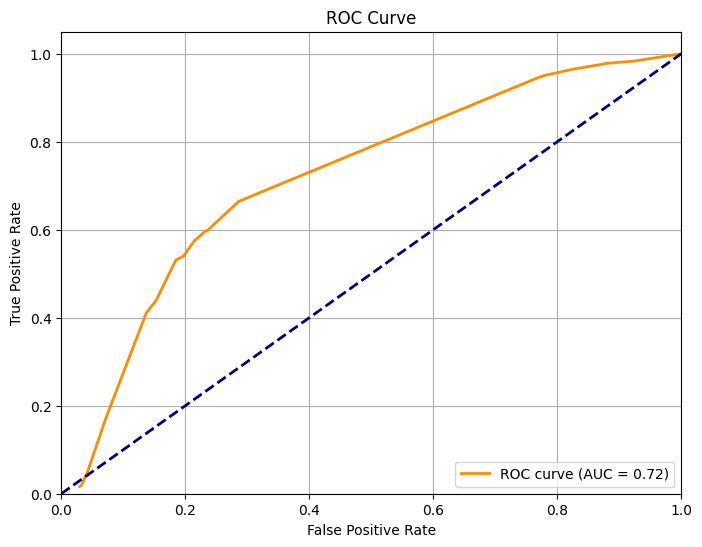

In [28]:
true_sentiments = dt_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_probs = dt_predictions.select('probability').rdd.flatMap(lambda x: x).collect()

true_binary = [1 if sentiment == 1 else 0 for sentiment in true_sentiments]

fpr, tpr, _ = calculate_roc_curve(true_binary, predicted_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
spark.stop()

### 10. Random Forest

In [29]:
spark = SparkSession.builder.appName("RandomForest").config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").getOrCreate()
spark_df = spark.createDataFrame(df_pandas.head(70000))
spark_df = spark_df.withColumn("Sentiment", when(col("Score") >= 4, 1).otherwise(0))
tokenizer, remover, hashingTF, idf= pipeline_stage()
rf = RandomForestClassifier(labelCol="Sentiment", featuresCol="features")
pipeline_polynomial = Pipeline(stages=[tokenizer, remover, hashingTF, idf, rf])
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction")
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()
crossval = CrossValidator(estimator=pipeline_polynomial, 
                          estimatorParamMaps=param_grid, 
                          evaluator=evaluator, 
                          numFolds=3)
train_data, test_data = spark_df.randomSplit([0.7, 0.3], seed=42)
model = crossval.fit(train_data)
rf_predictions = model.transform(test_data)

23/10/20 03:11:25 WARN StopWordsRemover: Default locale set was [en_TH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
23/10/20 03:11:26 WARN StopWordsRemover: Default locale set was [en_TH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
23/10/20 03:11:26 WARN StopWordsRemover: Default locale set was [en_TH]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
23/10/20 03:11:27 WARN TaskSetManager: Stage 0 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:11:28 WARN TaskSetManager: Stage 1 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:11:31 WARN TaskSetManager: Stage 3 contains a task of very large si

### 10.1 Random Forest - Evaluation

In [30]:
accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName:"accuracy"})
precision = evaluator.evaluate(rf_predictions, {evaluator.metricName:"weightedPrecision"})
recall = evaluator.evaluate(rf_predictions, {evaluator.metricName:"weightedRecall"})
f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName:"f1"})
bi_evaluator = BinaryClassificationEvaluator(labelCol="Sentiment", rawPredictionCol='probability')
auc = bi_evaluator.evaluate(rf_predictions, {bi_evaluator.metricName:"areaUnderROC"})
print(f"Accuracy: {accuracy * 100}%")
print(f"Precision: {precision * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1-Score: {f1 * 100}%")
print(f"AUC: {auc * 100:.2f}%")

23/10/20 03:38:41 WARN DAGScheduler: Broadcasting large task binary with size 1848.5 KiB
23/10/20 03:38:41 WARN TaskSetManager: Stage 882 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1848.5 KiB
23/10/20 03:38:44 WARN TaskSetManager: Stage 884 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1848.5 KiB
23/10/20 03:38:47 WARN TaskSetManager: Stage 886 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:38:49 WARN DAGScheduler: Broadcasting large task binary with size 1848.5 KiB
23/10/20 03:38:49 WARN TaskSetManager: Stage 888 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:38:51 WARN DAGScheduler: Broadcasting large task binary with

Accuracy: 76.8121552308139%
Precision: 82.1909988814064%
Recall: 76.8121552308139%
F1-Score: 66.77795382008958%
AUC: 83.16%


### 10.2 Random Forest - Histrogram

23/10/20 03:39:06 WARN TaskSetManager: Stage 901 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:39:09 WARN DAGScheduler: Broadcasting large task binary with size 1833.9 KiB
23/10/20 03:39:09 WARN TaskSetManager: Stage 902 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


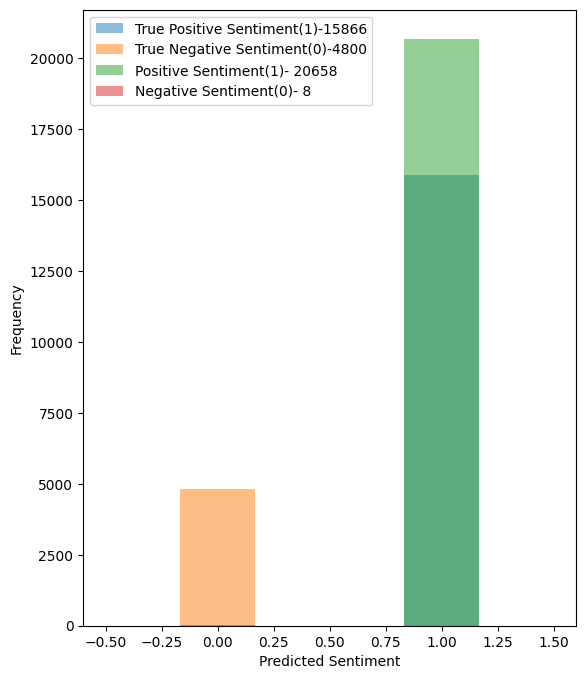

In [31]:
true_sentiments = rf_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_sentiments = rf_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

positive_true = [pred for pred in true_sentiments if pred ==1]
negative_true = [pred for pred in true_sentiments if pred ==0]
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 2)
plt.hist(positive_true, bins=3, alpha=0.5, label=f'True Positive Sentiment(1)-{len(positive_true)}')
plt.hist(negative_true, bins=3, alpha=0.5, label=f'True Negative Sentiment(0)-{len(negative_true)}')
plt.xlabel('True Sentiment')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
positive_predictions = [pred for pred in predicted_sentiments if pred == 1]
negative_predictions = [pred for pred in predicted_sentiments if pred == 0]

plt.hist(positive_predictions, bins=3, alpha=0.5, label=f'Positive Sentiment(1)- {len(positive_predictions)}')
plt.hist(negative_predictions, bins=3, alpha=0.5, label=f'Negative Sentiment(0)- {len(negative_predictions)}')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Frequency')
plt.legend()

plt.show()

### 10.3 Random Forest - Confusion Matrix

23/10/20 03:39:29 WARN TaskSetManager: Stage 903 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:39:30 WARN DAGScheduler: Broadcasting large task binary with size 1833.9 KiB
23/10/20 03:39:31 WARN TaskSetManager: Stage 904 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


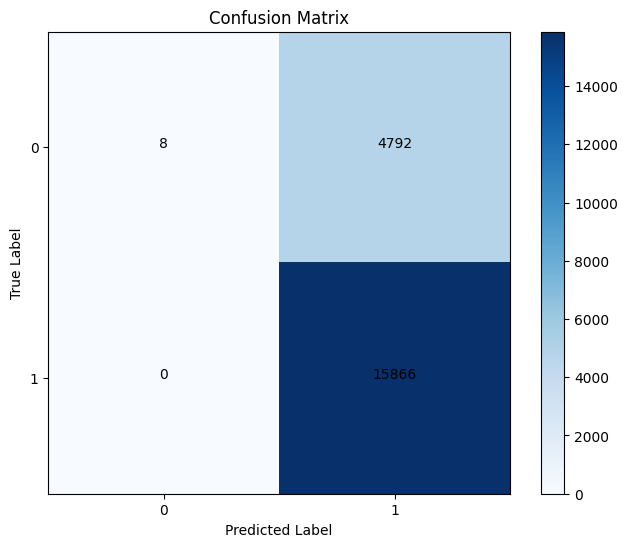

In [32]:
true_sentiments = rf_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_sentiments = rf_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 6))
plot_confusion_matrix(true_sentiments, predicted_sentiments)
plt.show()

### 10.4 Random Forest - ROC Curve

23/10/20 03:39:39 WARN TaskSetManager: Stage 905 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.
23/10/20 03:39:40 WARN DAGScheduler: Broadcasting large task binary with size 1837.4 KiB
23/10/20 03:39:40 WARN TaskSetManager: Stage 906 contains a task of very large size (3950 KiB). The maximum recommended task size is 1000 KiB.


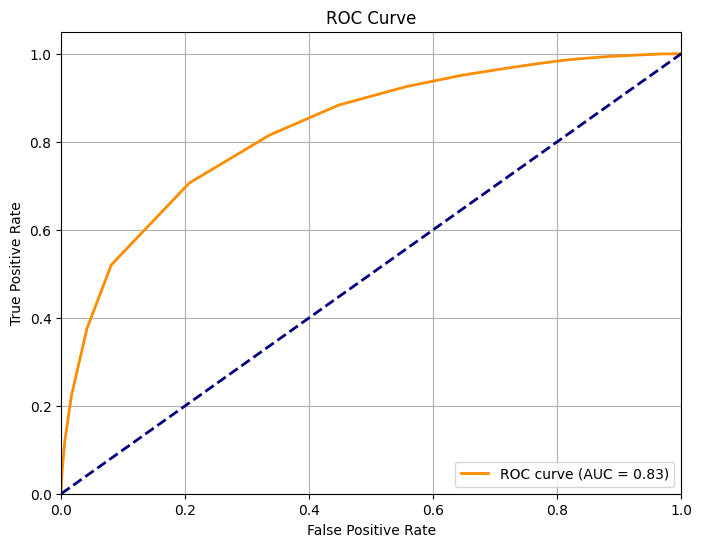

In [33]:
true_sentiments = rf_predictions.select('Sentiment').rdd.flatMap(lambda x: x).collect()
predicted_probs = rf_predictions.select('probability').rdd.flatMap(lambda x: x).collect()

true_binary = [1 if sentiment == 1 else 0 for sentiment in true_sentiments]

fpr, tpr, _ = calculate_roc_curve(true_binary, predicted_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
spark.stop()